In [2]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageChops,ImageEnhance

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
Au_folder_path = "/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au" # authentic image folder
Tp_folder_path = "/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp" # tampered image folder
Au_image_files = [f for f in os.listdir(Au_folder_path) if f.endswith(('.jpg', '.jpeg', '.png','.bmp','.tif'))]
Tp_image_files = [f for f in os.listdir(Tp_folder_path) if f.endswith(('.jpg', '.jpeg', '.png','.bmp','.tif'))]

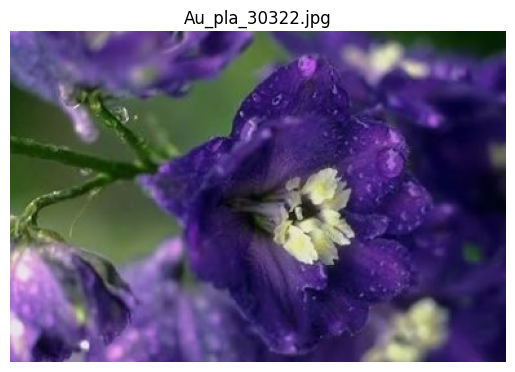

In [4]:
for i in range(1):
    # Construct the full path to the image
    image_path = os.path.join(Au_folder_path, Au_image_files[i])

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.title(Au_image_files[i])  # Show the filename as the title
    plt.axis('off')
    plt.show()

In [5]:
len(Au_image_files),len(Tp_image_files)

(7491, 5123)

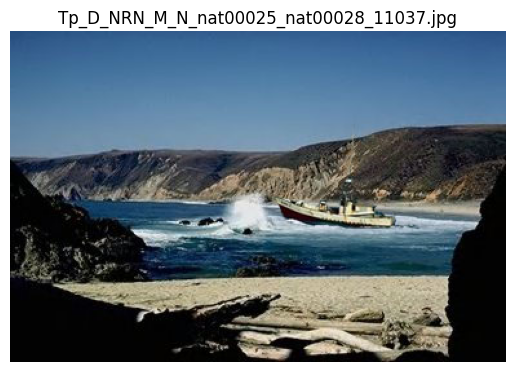

In [6]:
for i in range(1):
    # Construct the full path to the image
    image_path = os.path.join(Tp_folder_path, Tp_image_files[i])

    # Load the image
    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

     # Display the image
    plt.imshow(image_rgb)
    plt.title(Tp_image_files[i])  # Show the filename as the title
    plt.axis('off')
    plt.show()

In [7]:

def compute_ela(path, quality=100):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png' 
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff 
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)  
    return ela_image


In [8]:
image_size=(128,128)

In [9]:
def preprocessing(image_path):
    return np.array(compute_ela(image_path).resize(image_size))/255

In [10]:
a=preprocessing("/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif")

In [11]:
a.shape

(128, 128, 3)

In [12]:
X=[]
Y=[]

In [13]:
import random
path = Au_folder_path
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith(('.jpg', '.jpeg', '.png','.bmp','.tif')):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(1)
random.shuffle(X)
X = X[:5100]
Y = Y[:5100]
print(len(X), len(Y))

5100 5100


In [14]:
path = Tp_folder_path
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith(('.jpg', '.jpeg', '.png','.bmp','.tif')):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(0)
print(len(X), len(Y))

10223 10223


In [15]:
from tensorflow.keras.utils import to_categorical
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [16]:
X.shape,Y.shape

((10223, 128, 128, 3), (10223, 2))

In [17]:
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,random_state=10)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

8178 8178
2045 2045


In [18]:
X.shape

(502480896, 1, 1, 1)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
def CNN():
    model = Sequential()
    model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0.35))
    model.add(BatchNormalization())
    model.add(Dense(units=16,activation='relu'))
    model.add(Dropout(0.45))
    model.add(BatchNormalization())
    model.add(Dense(units=2,activation='sigmoid'))
    return model

In [20]:
model1=CNN()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 256)       819456    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 256)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 215296)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.9, 
                                            min_lr=0.00001)

In [23]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [24]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

epochs = 120
batch_size = 32
init_lr = 1e-3

# Defining a learning rate schedule using ExponentialDecay
lr_schedule = ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=epochs,
    decay_rate=0.9,
    staircase=True
)

# Use the learning rate schedule in the Adam optimizer
optimizer = Adam(learning_rate=lr_schedule)

model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
# Fit the model
history = model1.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 120, validation_data = (X_val,Y_val),
                               steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,earlystopping])

Epoch 1/120
255/255 [==============================] - 43s 140ms/step - loss: 0.5301 - accuracy: 0.7849 - val_loss: 0.5175 - val_accuracy: 0.7017 - lr: 8.1000e-04
Epoch 2/120
255/255 [==============================] - 32s 127ms/step - loss: 0.4273 - accuracy: 0.8452 - val_loss: 0.3286 - val_accuracy: 0.8792 - lr: 6.5610e-04
Epoch 3/120
255/255 [==============================] - 33s 127ms/step - loss: 0.3954 - accuracy: 0.8624 - val_loss: 0.3078 - val_accuracy: 0.8949 - lr: 5.3144e-04
Epoch 4/120
255/255 [==============================] - 32s 126ms/step - loss: 0.3585 - accuracy: 0.8759 - val_loss: 0.4555 - val_accuracy: 0.7658 - lr: 4.3047e-04
Epoch 5/120
255/255 [==============================] - 32s 127ms/step - loss: 0.3387 - accuracy: 0.8834 - val_loss: 0.8134 - val_accuracy: 0.7002 - lr: 3.4868e-04
Epoch 6/120
255/255 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.8922
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00025418653094675395.
255/255 [==

In [26]:
loss,accuracy=model1.evaluate(X_val, Y_val)

64/64 [==============================] - 1s 19ms/step - loss: 0.3078 - accuracy: 0.8949


In [27]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/tmp/ipykernel_2064/919921037.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1) #horizontal,vertical,position


64/64 [==============================] - 1s 17ms/step


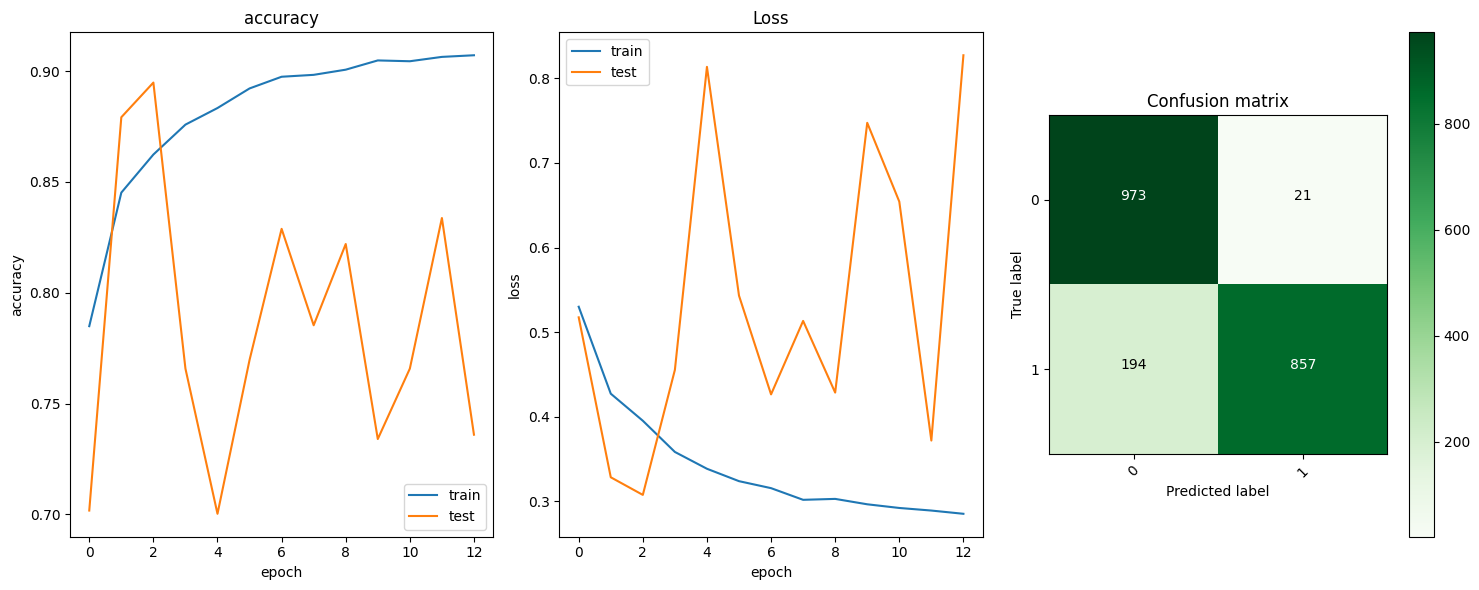

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.subplots(figsize=(15, 6))
plt.subplot(1,3,1) #horizontal,vertical,position
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.subplot(1,3,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.subplot(1,3,3)
Y_pred = model1.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.show()